In [1]:
#Projekt ma na celu wczytanie plików wav oraz txt zawierających identyczną sekwencję komend
#Filtrację sygnału, wizualizację, a także analizę zarówną ręczną jak i z wykorzystaniem machine learning

#każdy etap prac opatrzony jest komentarzami z opisem i wnioskami powstałymi w czasie tworzenia kodu

In [9]:
from scipy.io import wavfile
import scipy.signal as sg
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

%matplotlib inline

In [10]:
######################################## WCZYTANIE PLIKU ##########################################################

In [11]:
# wczytywanie pliku
# należy podać ścieżkę do folderu, w którym zajdują się nagrania, lub foldery z nagraniami
# podano dwa warianty ścieżki dla różnych systemów 

#system macOS
data_dir = "/Users/anita/downloads/nagrania_projekt"
#system windows
#data_dir = "C:\\data"

In [12]:
signals = []
annotations = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".txt"):
            annotations.append(os.path.join(root, file))
        elif file.endswith(".wav"):
            signals.append(os.path.join(root, file))

In [13]:
#z plików wczytywane są osobno fragmenty nagrań ze słowami, a także cisza w celu usunięcia szumów tła w dalszym etapie

rows = []
silence = []

for idx, signal in enumerate(signals):
#system macOS
    info = signal.split("/")[-1].split("_")
#system windows
    #info = signal.split("\\")[-1].split("_")
    single_ann = pd.read_csv(annotations[idx], sep='\t', header=-1, names=['start', 'end', 'command'])
    fs, data = wavfile.read(signal)
    row = {'subject': info[0], 
           'age': int(info[1]), 
           'gender': info[2], 
           'time': info[3], 
           'rec_no': int(info[4].split(".")[0]), 
           'fs': fs}
    
    for idx, r in single_ann.iterrows():
        cmd_row = {}
        st = round(r['start'] * fs)
        en = round(r['end'] * fs)
        if idx == 0:
            silence.append(data[0:st])
            #print("Silence")
            #print(silence)       

        cmd_row['command'] = str(r['command'])
        if len(data.shape) > 1:
            cmd_row['ch_1'] = data[:, 0][st:en]
            cmd_row['ch_2'] = data[:, 1][st:en]
            cmd_row['duration'] = data[:, 0][st:en].shape[0] / fs
        else:
            cmd_row['ch_1'] = data[st:en]
            cmd_row['ch_2'] = None
            cmd_row['duration'] = data[st:en].shape[0] / fs
        

        rows.append(dict(cmd_row, **row))
    
    
dataset = pd.DataFrame.from_dict(rows)
dataset.columns
dataset.head()

,age,ch_1,ch_2,command,duration,fs,gender,rec_no,subject,time
0,23,"[4, -12, -28, -31, -18, 3, 15, 10, -6, -18, -2...","[4, -12, -28, -31, -18, 3, 15, 10, -6, -18, -2...",WLACZ,0.682302,96000,K,4,22,23
1,23,"[-3, -4, -8, -11, -11, -9, -10, -13, -14, -11,...","[-3, -4, -8, -11, -11, -9, -10, -13, -14, -11,...",WYLACZ,0.887000,96000,K,4,22,23
2,23,"[-9, -13, -14, -13, -10, -8, -6, -5, -7, -10, ...","[-9, -13, -14, -13, -10, -8, -6, -5, -7, -10, ...",ZWIEKSZ,0.864260,96000,K,4,22,23
3,23,"[-6, -1, 2, 1, -1, -1, 0, -1, -4, -6, -5, -2, ...","[-6, -1, 2, 1, -1, -1, 0, -1, -4, -6, -5, -2, ...",ZMNIEJSZ,0.864250,96000,K,4,22,23
4,23,"[-10, -8, -6, -4, -4, -2, 1, 4, 4, 3, 4, 8, 13...","[-10, -8, -6, -4, -4, -2, 1, 4, 4, 3, 4, 8, 13...",OTWORZ,0.796031,96000,K,4,22,23


In [14]:
########################################## FILTRACJA ############################################################

In [15]:
#kolejny etap przedstawia filtrację sygnałów
#ponieważ część plików wav nie posiada drugiego kanału, do dalszej analizy wykorzystano jedynie pierwszy kanał

In [16]:
#dla przykładowego pliku wyświetlono sygnały wszystkich komend nieprzefiltrowanego sygnału

In [17]:
subject = dataset.loc[(dataset['subject'] == '276123') & (dataset['rec_no'] == 1)]
subject.head()

,age,ch_1,ch_2,command,duration,fs,gender,rec_no,subject,time
357,49,"[366, 362, 368, 323, 267, 299, 345, 370, 373, ...",None,WLACZ,0.851497,44100,K,1,276123,08
358,49,"[4, 1, 4, 4, 5, 3, 2, 5, 7, 3, 8, 4, 7, 6, 1, ...",None,WYLACZ,1.182630,44100,K,1,276123,08
359,49,"[-508, -1776, -584, 1220, 1635, 793, -371, -83...",None,ZWIEKSZ,0.850612,44100,K,1,276123,08
360,49,"[18, 21, 22, 23, 30, 68, 90, 71, 51, 30, 42, 4...",None,ZMNIEJSZ,0.872993,44100,K,1,276123,08
361,49,"[-109, -122, -79, -120, -99, -119, -163, -97, ...",None,OTWORZ,0.805850,44100,K,1,276123,08


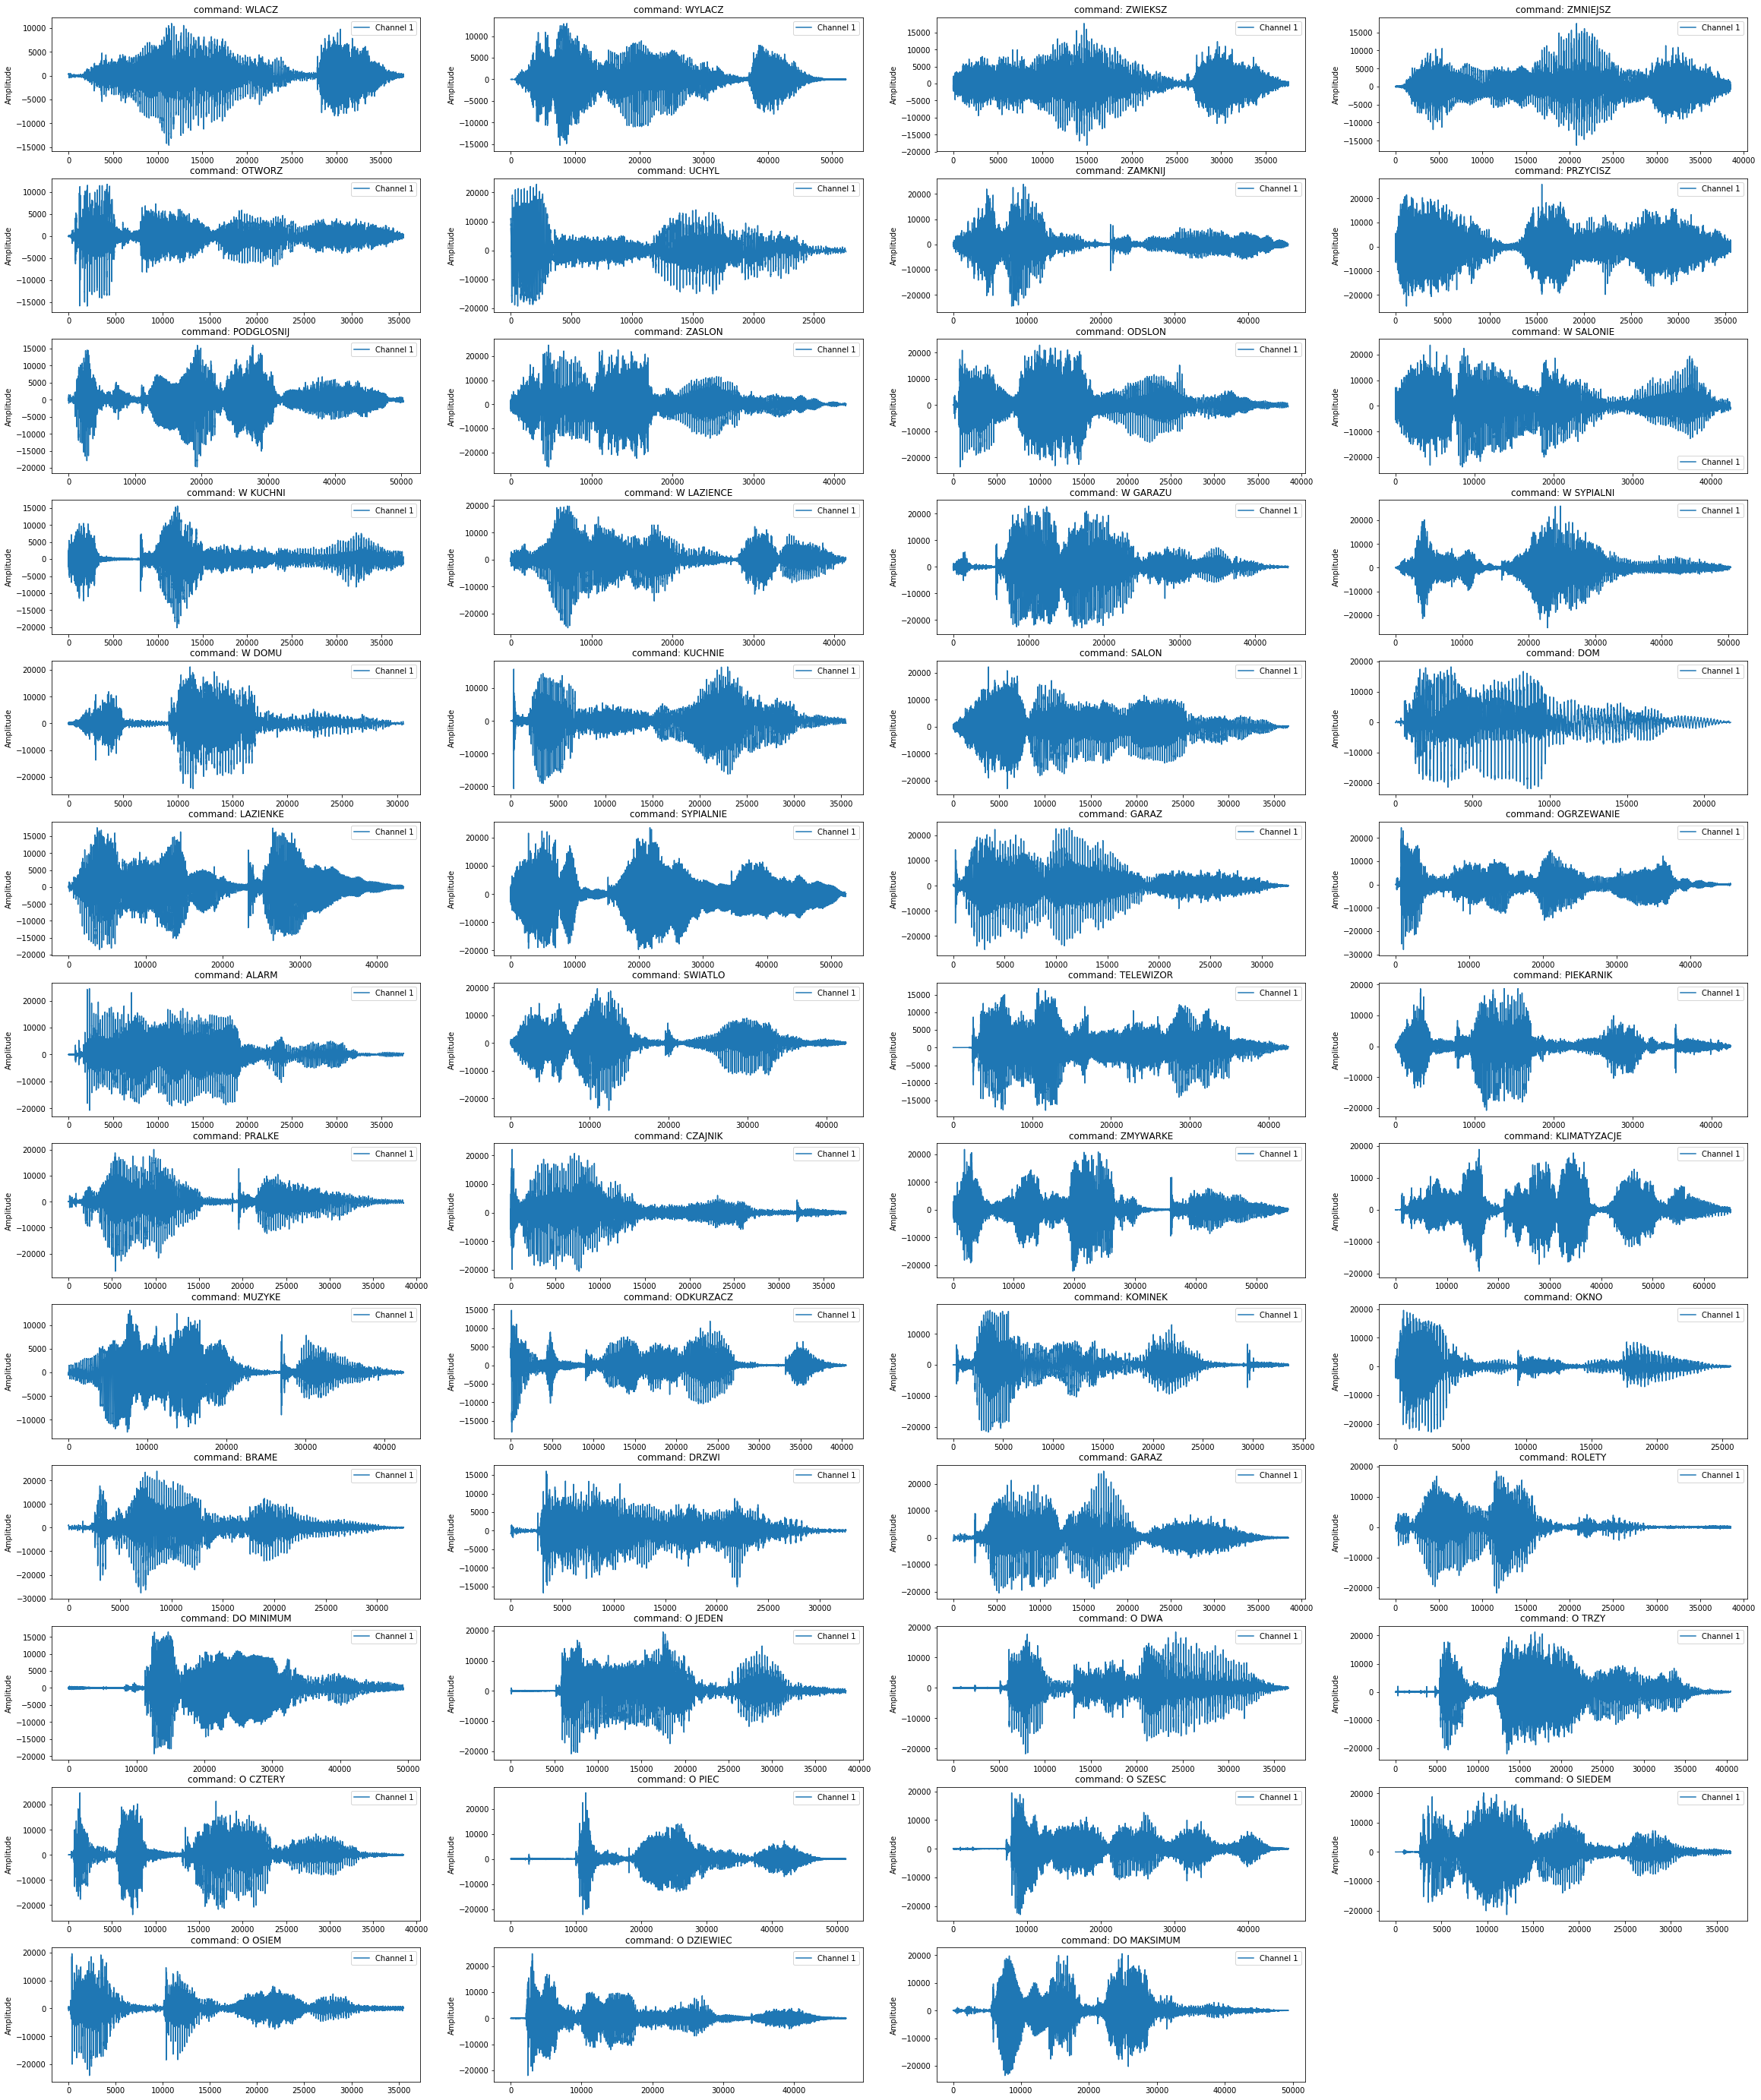

In [60]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(13,4,n)
    plt.plot(row['ch_1'], label="Channel 1")
    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [61]:
#w kolejnym kroku zastosowano filtr pasmowo-przepustowy Butterwortha i wyświetlono wykresy
# przefiltrowanego sygnału dla wyżej użytego pliku

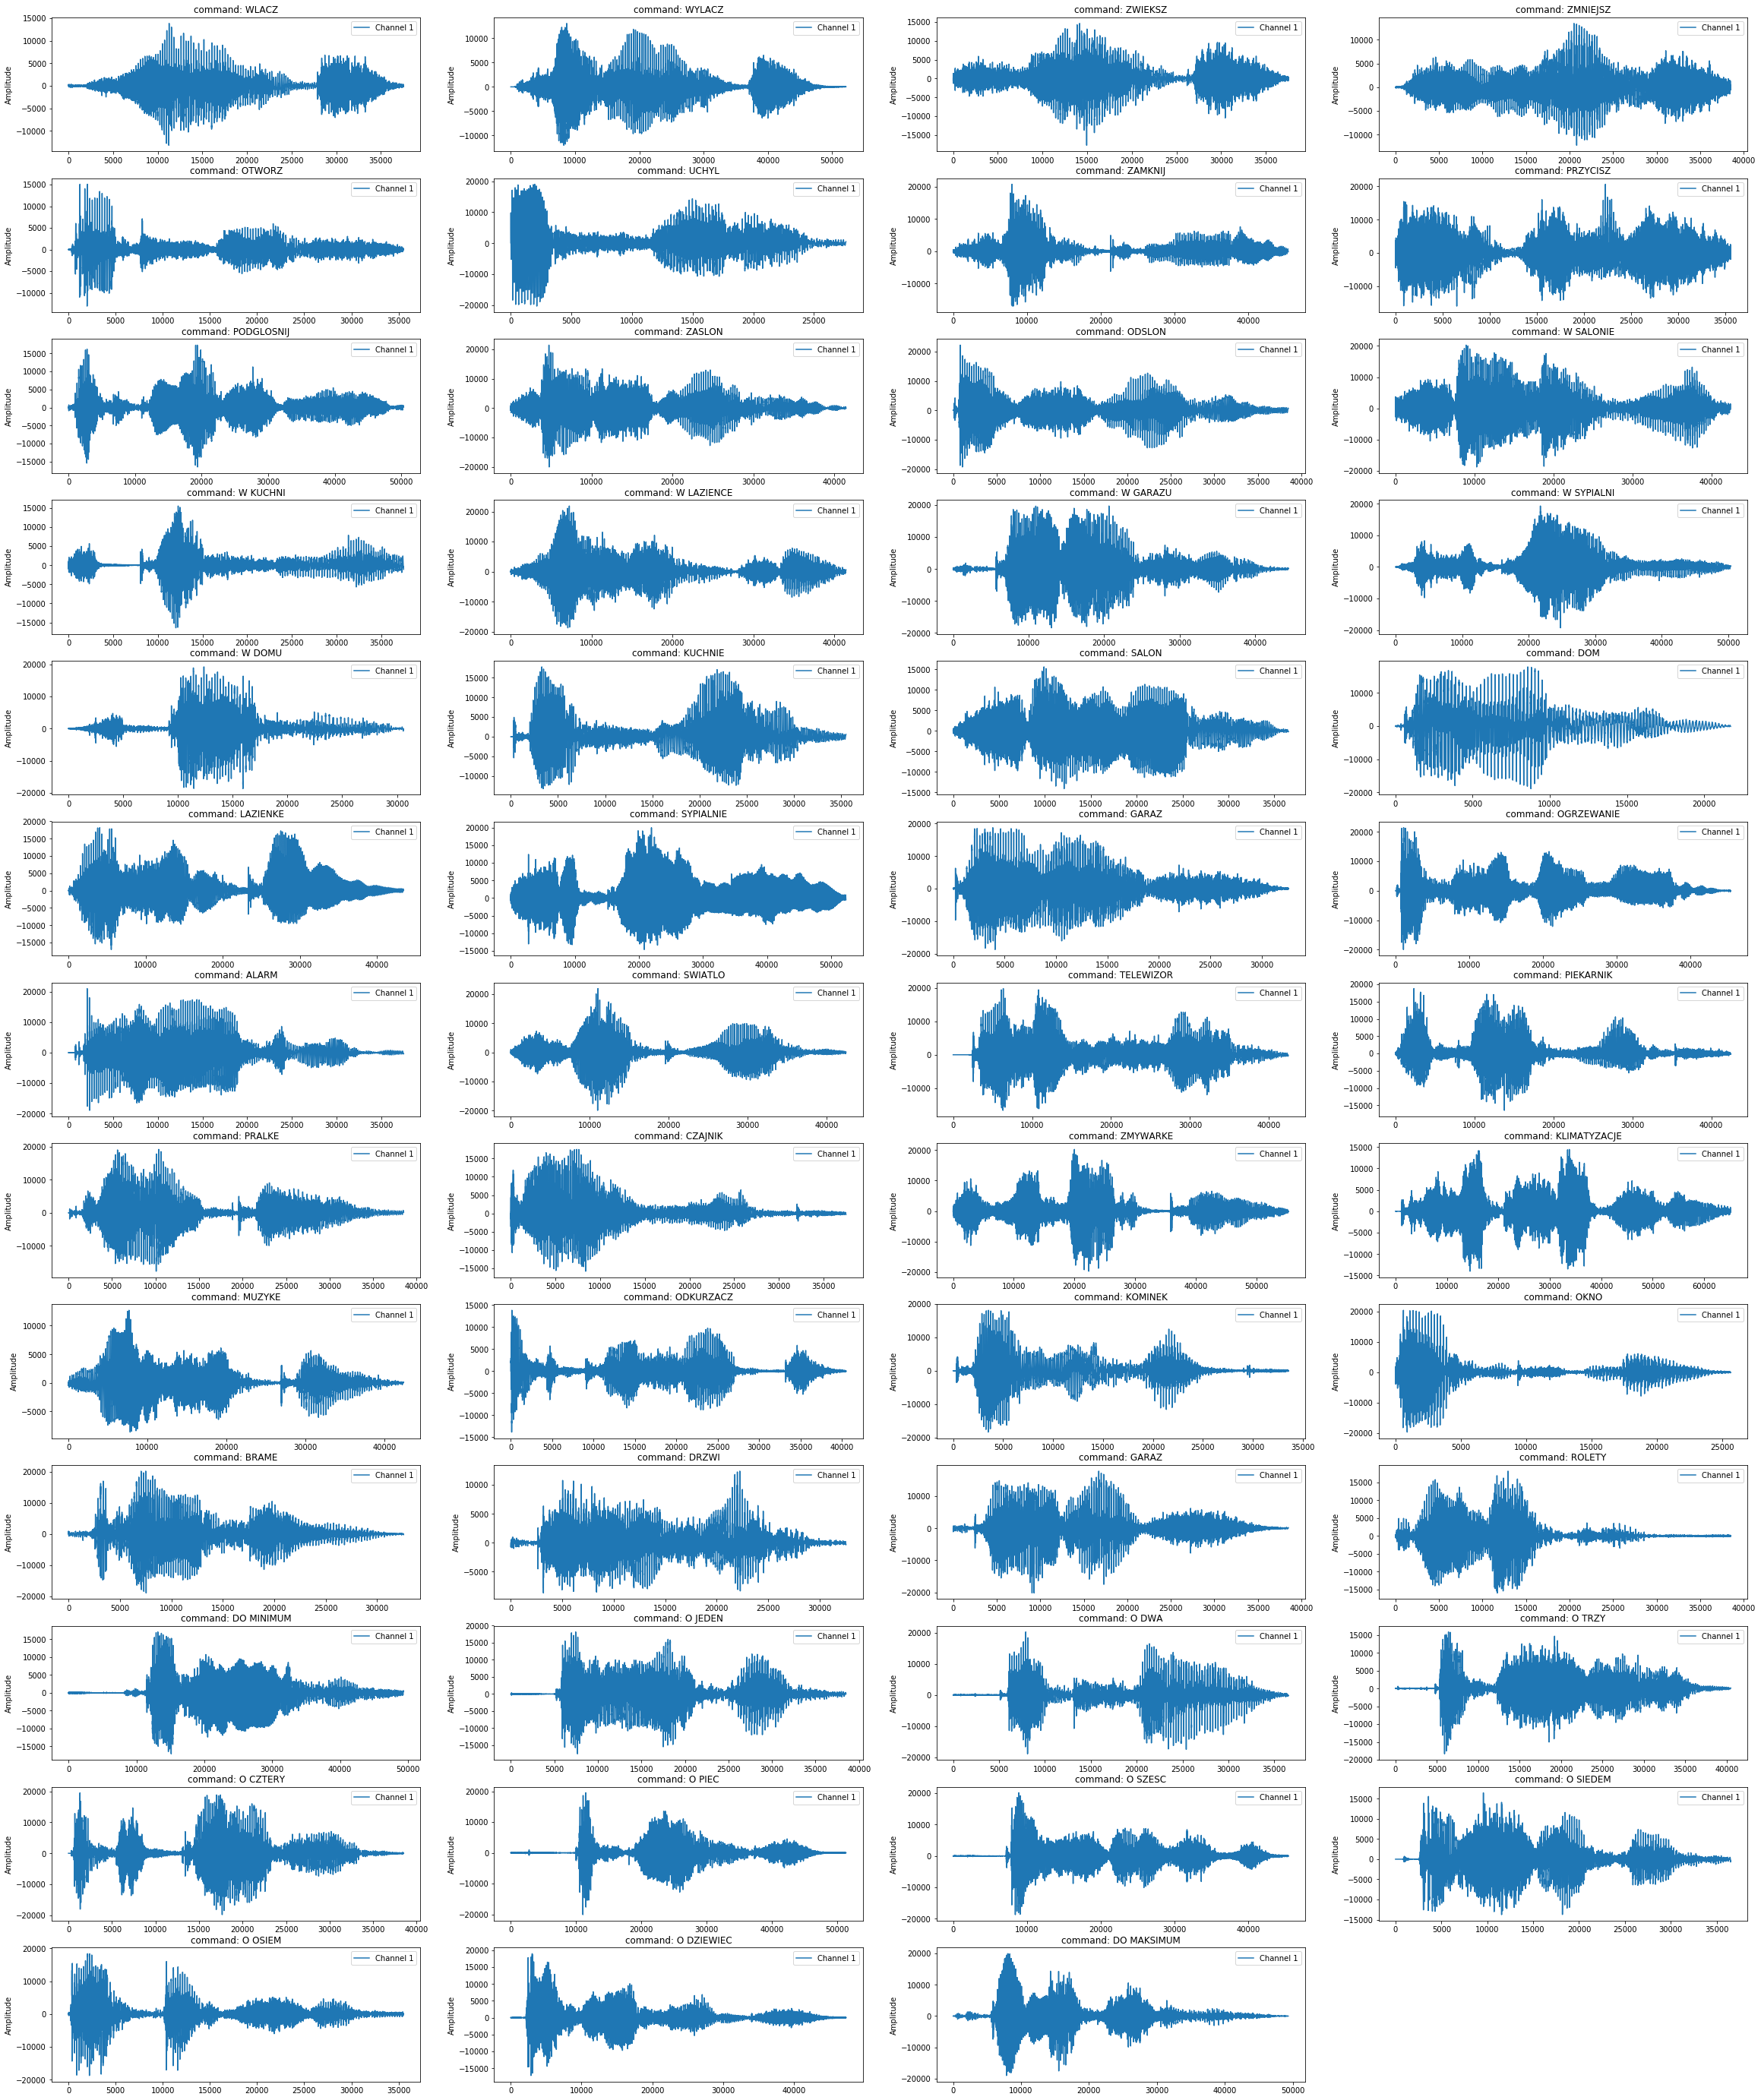

In [62]:
plt.figure(figsize=(40,50))
n = 1

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

for idx, row in subject.iterrows():
    record = row['ch_1'];
    record_filtered= butter_bandpass_filter(record,200, 8000, fs);

    

    
    plt.subplot(13,4,n)
    plt.plot(record_filtered, label="Channel 1")
    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    wavfile.write("example.wav", fs, record_filtered);    
    n += 1
    
plt.show()

In [1]:
#w celu analizy cech wykorzystano również funkcję Fouriera przedstawiającą zależność amplitudy od częstotliwości
#dla kolejnych komend

In [ ]:
#UWAGA: funkcja obciąża pamięć RAM i nie uruchamia się dla niektórych komputerów

plt.figure(figsize=(40,50))
n = 1
record_after = np.array
lowpass_freq = 200   #removes low frequencies
highpass_freq = 8000    #removes high frequencies

for idx, row in subject.iterrows():
    record = row['ch_1']

    fft_silence = np.fft.rfft(silence[row['rec_no']], n=len(record))
    fft_record = np.fft.rfft(record)
    fft_result = fft_record - fft_silence

    fft_result[:lowpass_freq] = 0   # All frequencues below the lowpass are set to 0
    fft_result[highpass_freq:] = 0  # All frequencies above the highpass are set to 0

    record_after_filtering = np.fft.irfft(fft_result)

    plt.subplot(13,4,n)
    plt.plot(abs(fft_result), label="FFT CH_1")
    plt.plot(abs(fft_silence), label="FFT Silence")
    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency [Hz]")
#należy podać ścieżkę analogicznie jak przy wczytywaniu plików    
    wavfile.write("/Users/anita/downloads/nagrania_projekt" + str(n) + ".wav", 48000, record_after_filtering)
    n += 1
    
plt.show()

In [ ]:
#################################### WIZUALIZACJA PRZYKŁADOWYCH KOMEND ##############################################

In [13]:
#w celu wizualizacji różnic przedstawione zostały wykresy słowa włącz, wyłącz, przycisz, o sześć, telewizor, klimatyzacja
#ma to na celu zobrazowanie różnic dla słów najczęściej używanych o podobnym brzmieniu, słowa 'szeleszczące', 
#a także długie i z dużą ilością samogłosek
#porównanie przedstawiono dla trzech różnych nagrań - kobiet w różnym wieku (23 i 49), a także dla głosu męskiego

#ponieważ nie zauważono znaczącej różnicy pomiędzy sygnałem orginalnym i przefiltrowanym
#do celów analizy wykorzystano pliki orginalne

In [24]:
#wizualizacja komend WLACZ - rozne osoby
subject = dataset.loc[((dataset['subject'] == '276123') | (dataset['subject'] == '284348') | (dataset['subject'] == '284400'))  & (dataset['command'] == 'WLACZ')]
subject.head()

,age,ch_1,ch_2,command,duration,fs,gender,rec_no,subject,time
204,49,"[-298, -289, -300, -298, -374, -340, -476, -51...",None,WLACZ,0.916871,44100,K,3,276123,20
255,49,"[-398, 178, 116, 399, -17, -420, 45, 294, 74, ...",None,WLACZ,0.775306,44100,K,4,276123,21
306,49,"[601, -399, -601, -455, 619, 560, 446, -933, -...",None,WLACZ,0.795442,44100,K,2,276123,16
357,49,"[366, 362, 368, 323, 267, 299, 345, 370, 373, ...",None,WLACZ,0.851497,44100,K,1,276123,08
765,23,"[50, 89, 130, 173, 217, 253, 285, 325, 371, 41...","[-213, -204, -192, -179, -168, -158, -147, -13...",WLACZ,0.410646,48000,K,2,284400,14


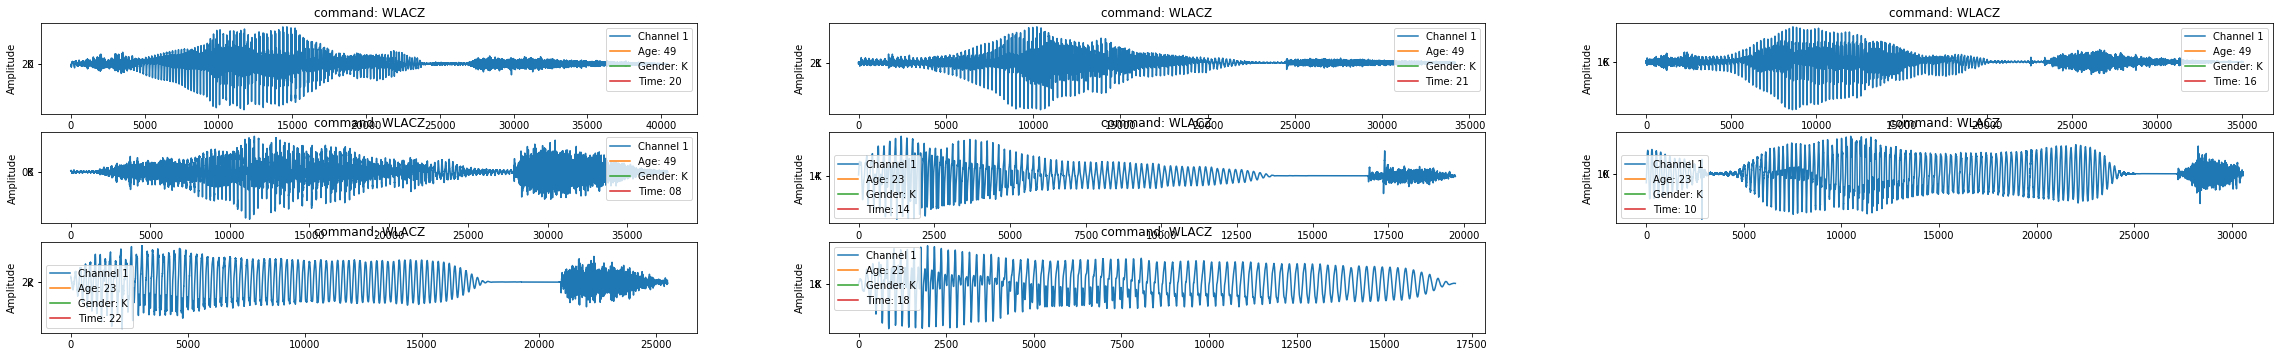

In [25]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['ch_1'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))

    
    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [26]:
#wizualizacja komend WYLACZ - rozne osoby
subject = dataset.loc[((dataset['subject'] == '276123') | (dataset['subject'] == '284348') | (dataset['subject'] == '284400'))  & (dataset['command'] == 'WYLACZ')]
subject.head()

,age,ch_1,ch_2,command,duration,fs,gender,rec_no,subject,time
205,49,"[-924, -818, -738, -861, -830, -1011, -953, -8...",None,WYLACZ,1.112494,44100,K,3,276123,20
256,49,"[287, 232, 284, 223, 138, 80, 47, 97, 49, -11,...",None,WYLACZ,0.996825,44100,K,4,276123,21
307,49,"[871, 792, 736, 753, 797, 760, 692, 667, 674, ...",None,WYLACZ,1.004059,44100,K,2,276123,16
358,49,"[4, 1, 4, 4, 5, 3, 2, 5, 7, 3, 8, 4, 7, 6, 1, ...",None,WYLACZ,1.182630,44100,K,1,276123,08
766,23,"[71, 65, 60, 56, 53, 46, 39, 35, 28, 21, 16, 1...","[60, 61, 60, 57, 57, 56, 55, 53, 51, 49, 49, 4...",WYLACZ,0.701083,48000,K,2,284400,14


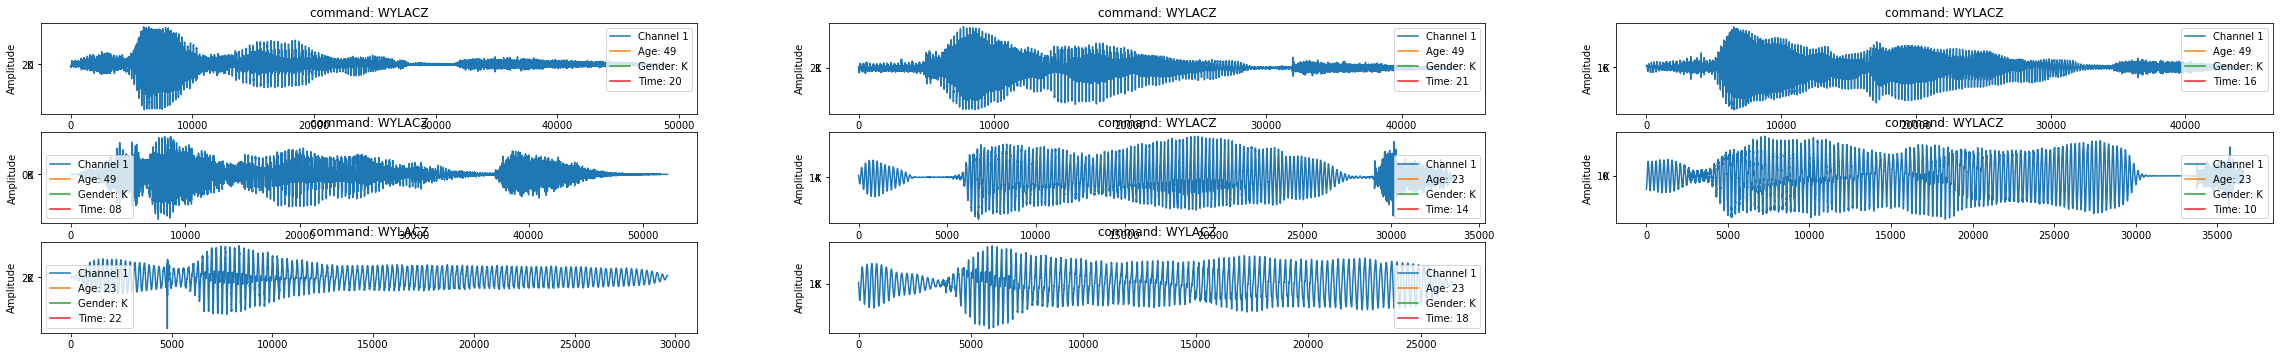

In [27]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['ch_1'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))

    
    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [32]:
#wizualizacja komend WLACZ I WYLACZ- ta sama osoba
subject = dataset.loc[( (dataset['subject'] == '276123'))  & ((dataset['command'] == 'WLACZ') | (dataset['command'] == 'WYLACZ'))]
subject.head()

,age,ch_1,ch_2,command,duration,fs,gender,rec_no,subject,time
204,49,"[-298, -289, -300, -298, -374, -340, -476, -51...",None,WLACZ,0.916871,44100,K,3,276123,20
205,49,"[-924, -818, -738, -861, -830, -1011, -953, -8...",None,WYLACZ,1.112494,44100,K,3,276123,20
255,49,"[-398, 178, 116, 399, -17, -420, 45, 294, 74, ...",None,WLACZ,0.775306,44100,K,4,276123,21
256,49,"[287, 232, 284, 223, 138, 80, 47, 97, 49, -11,...",None,WYLACZ,0.996825,44100,K,4,276123,21
306,49,"[601, -399, -601, -455, 619, 560, 446, -933, -...",None,WLACZ,0.795442,44100,K,2,276123,16


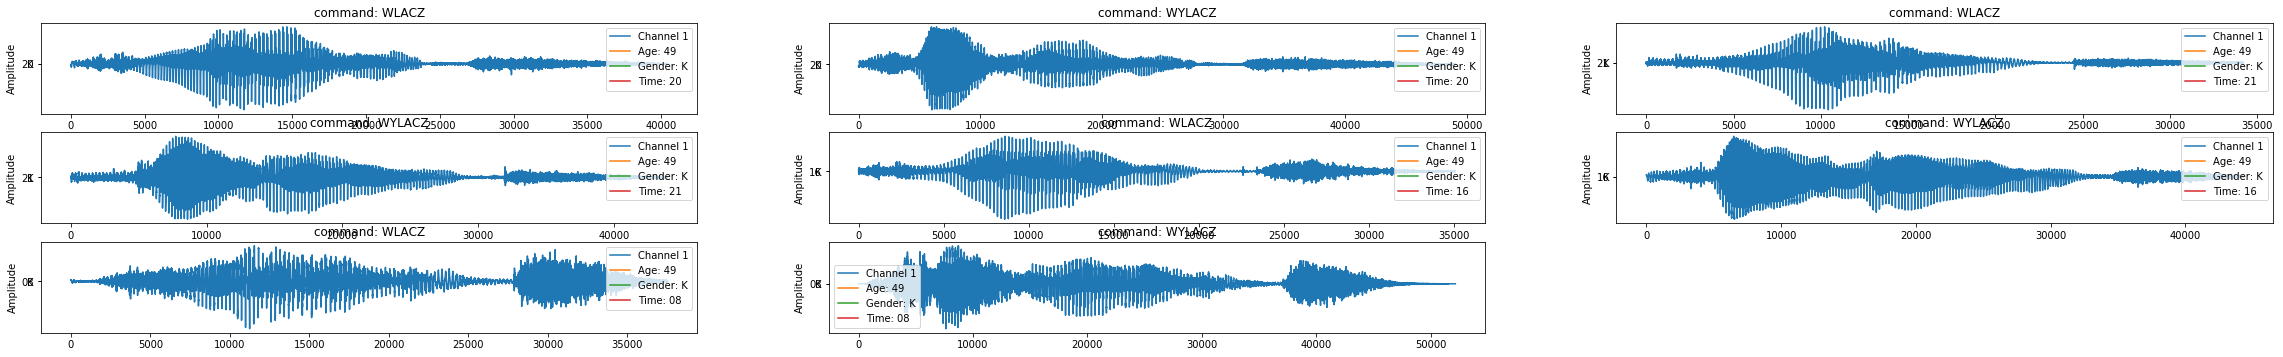

In [33]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['ch_1'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))


    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [34]:
#wizualizacja komend O SZESC i PRZYCISZ - rozne osoby
subject = dataset.loc[((dataset['subject'] == '276123') | (dataset['subject'] == '284348') | (dataset['subject'] == '284397'))  & ((dataset['command'] == 'PRZYCISZ') | (dataset['command'] == 'OSZESC') | (dataset['command'] == 'O SZESC'))]
subject.head()

,age,ch_1,ch_2,command,duration,fs,gender,rec_no,subject,time
211,49,"[-4, 2, 0, 0, 1, -1, 0, -1, 0, 0, 1, -1, 0, 0,...",None,PRZYCISZ,0.794649,44100,K,3,276123,20
250,49,"[-4, -7, -15, -1, -3, -2, -8, -8, 0, -7, -4, -...",None,O SZESC,0.929116,44100,K,3,276123,20
262,49,"[-18, -66, 85, -38, -54, -27, -57, -112, -104,...",None,PRZYCISZ,0.729161,44100,K,4,276123,21
301,49,"[-3784, -3890, -3532, -3362, -3202, -2613, -22...",None,O SZESC,0.959932,44100,K,4,276123,21
313,49,"[-65, -33, -148, -255, -80, -26, 110, 374, 87,...",None,PRZYCISZ,0.873673,44100,K,2,276123,16


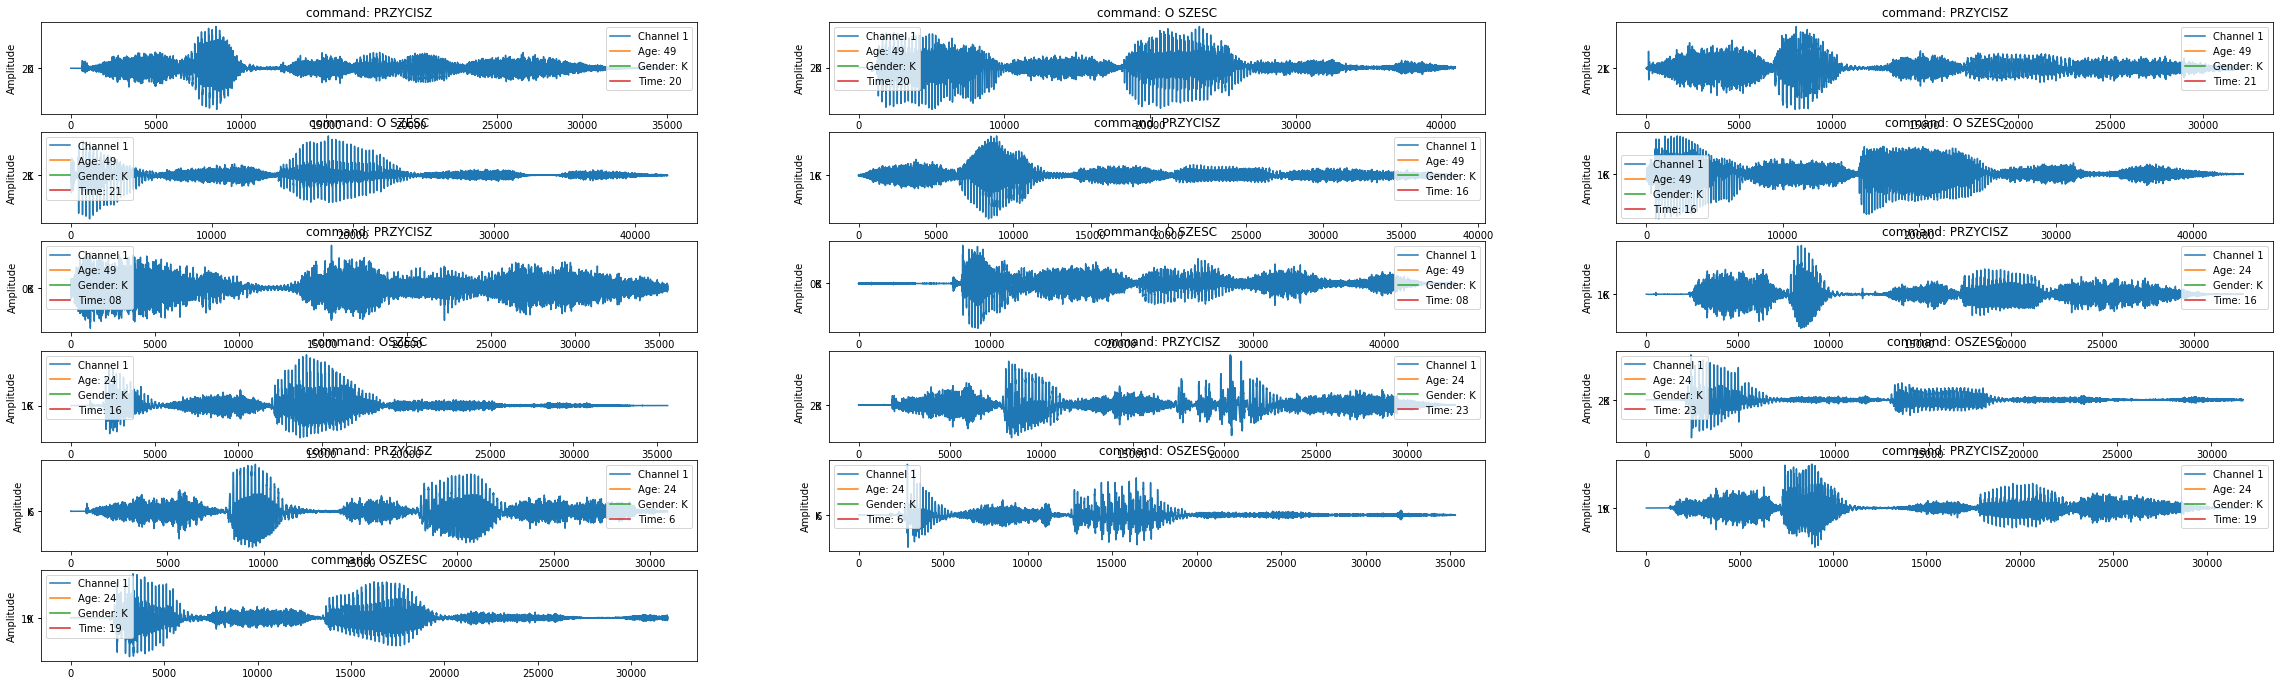

In [35]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['ch_1'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))


    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [38]:
#wizualizacja komendy KLIMATYZACJE - rozne osoby
subject = dataset.loc[((dataset['subject'] == '276123') | (dataset['subject'] == '284348') | (dataset['subject'] == '22'))  & ((dataset['command'] == 'KLIMATYZACJE'))]
subject.head()

,age,ch_1,ch_2,command,duration,fs,gender,rec_no,subject,time
31,23,"[8, 10, 11, 11, 7, 2, -1, 0, 3, 6, 5, 2, 3, 6,...","[8, 10, 11, 11, 7, 2, -1, 0, 3, 6, 5, 2, 3, 6,...",KLIMATYZACJE,1.114437,96000,K,4,22,23
82,23,"[1, 5, 6, 4, 0, 1, 4, 6, 4, 0, 0, 4, 8, 10, 9,...","[1, 5, 6, 4, 0, 1, 4, 6, 4, 0, 0, 4, 8, 10, 9,...",KLIMATYZACJE,1.238958,96000,K,1,22,19
133,23,"[-5, -5, -5, -2, 0, -1, -5, -9, -11, -7, 0, 5,...","[-5, -5, -5, -2, 0, -1, -5, -9, -11, -7, 0, 5,...",KLIMATYZACJE,1.195760,96000,K,3,22,09
184,23,"[-307, -287, -290, -304, -304, -273, -215, -15...","[-307, -287, -290, -304, -304, -273, -215, -15...",KLIMATYZACJE,1.323542,96000,K,2,22,12
235,49,"[-51, 3, 16, -15, 0, 5, 24, 5, -26, -9, -12, 3...",None,KLIMATYZACJE,1.430363,44100,K,3,276123,20


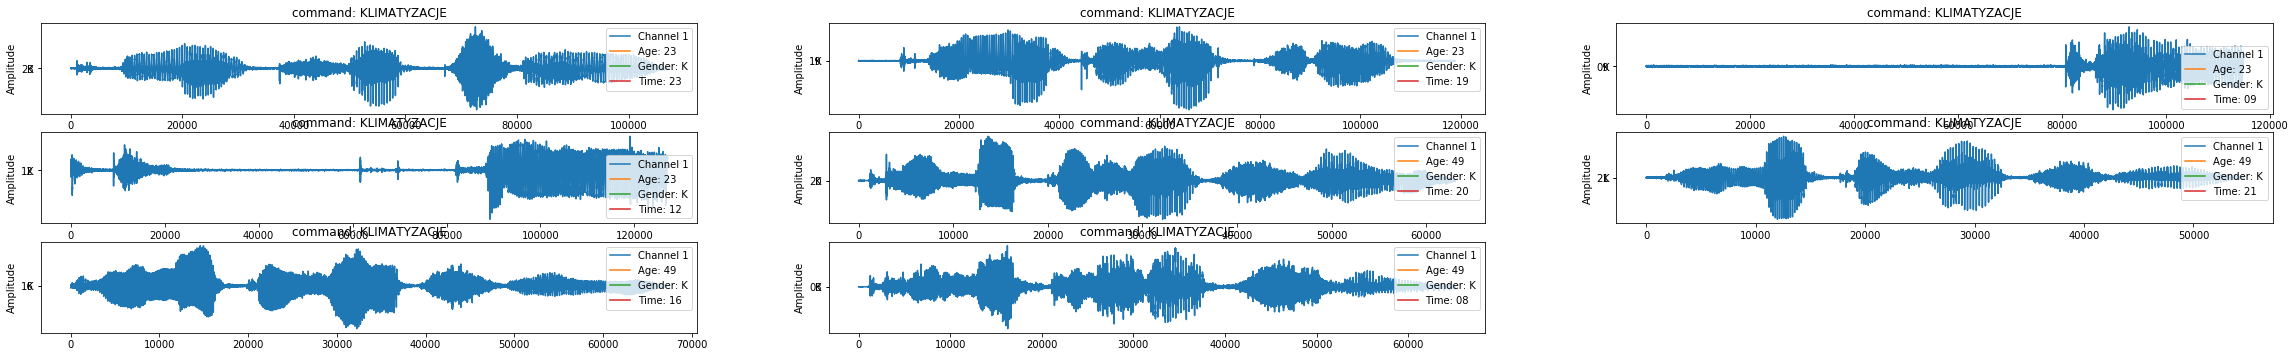

In [39]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['ch_1'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))


    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [ ]:
#wizualizacja komendy TELEWIZOR - rozne osoby
subject = dataset.loc[((dataset['subject'] == '276123') | (dataset['subject'] == '284348') | (dataset['subject'] == '22'))  & ((dataset['command'] == 'TELEWIZOR'))]
subject.head()

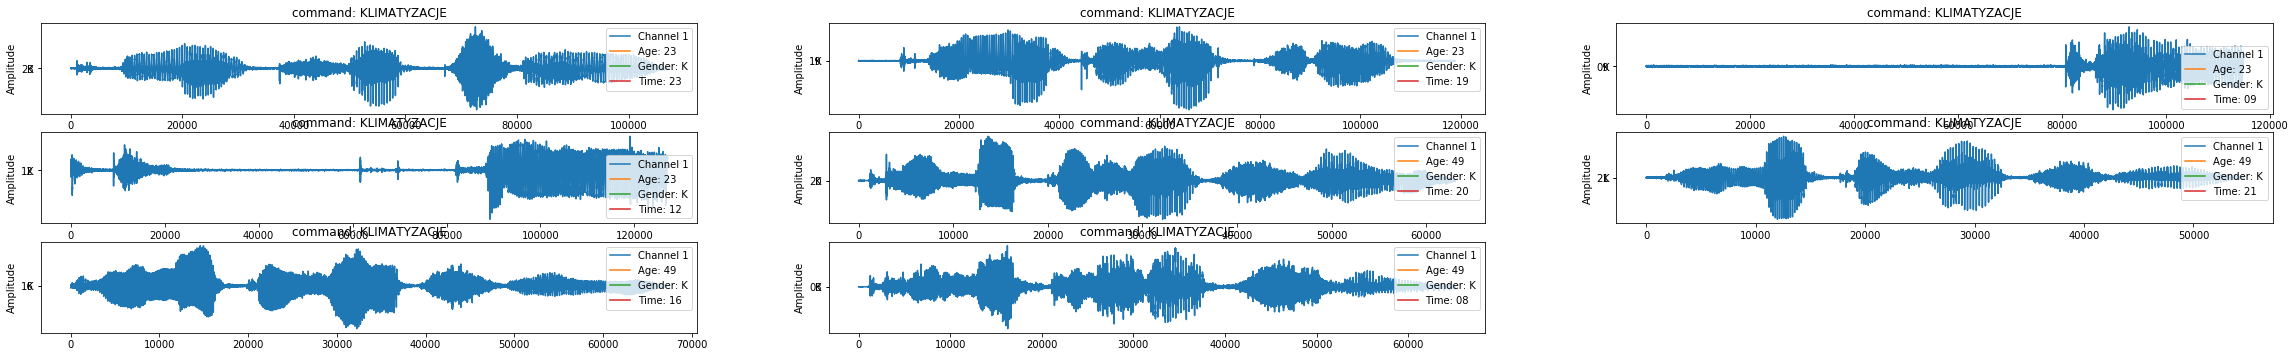

In [40]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['ch_1'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))


    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [ ]:
####### WNIOSKI NA PODSTAWIE WIZULIAZACJI
